In [141]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import warnings

In [142]:
warnings.filterwarnings(action = 'ignore')

In [731]:
df = pd.read_csv('C:/Users/whileduck/Desktop/캐글/train.csv').drop('id',axis = 1)

In [732]:
df.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


* 혈액 매개 질병에 대한 예측 모델 만들기인데 이번엔 시각화에 대해서 더욱 집중해보자  

### 그래프 기본 설정

In [733]:
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

### 원하는 상관 관계 표에서 원하는 컬러맵 설정

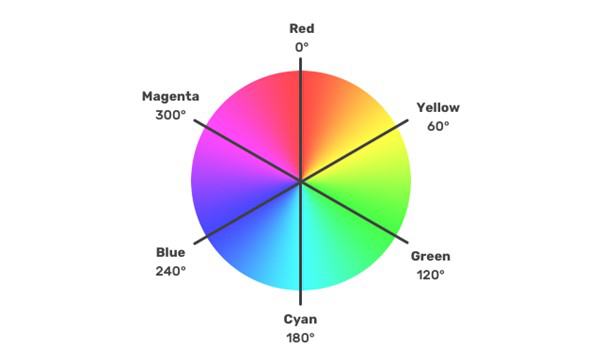

In [734]:
Image.open("C:/Users/whileduck/Desktop/033_2_색조그래프.jpg")

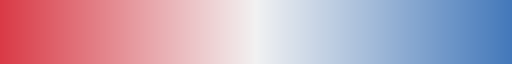

In [735]:
cmap = sns.diverging_palette(10, 250,as_cmap = True) # (0~359 사이의 숫자를 가지는 값을 넣어 시작점과 끝점을 지정)
                                                    # as_cmap 은 색상 개체로 저장 가능 유무


cmap

In [736]:
bounds = np.array([-1.0, -0.8, -0.6, -0.4, 0.4, 0.6, 0.8, 1.0]) # 원하는 색상 경계 설정

norm = mpl.colors.BoundaryNorm(bounds, cmap.N) #cmap.N 은 현재 cmap 객체에서 사용 가능한 색상의 수
                                                        # 해당 색상의 수를 bound 안의 값을 경계로 하여 경계 별 색상 지정 

Text(0.5, 1.0, 'Correlationship of Symptom')

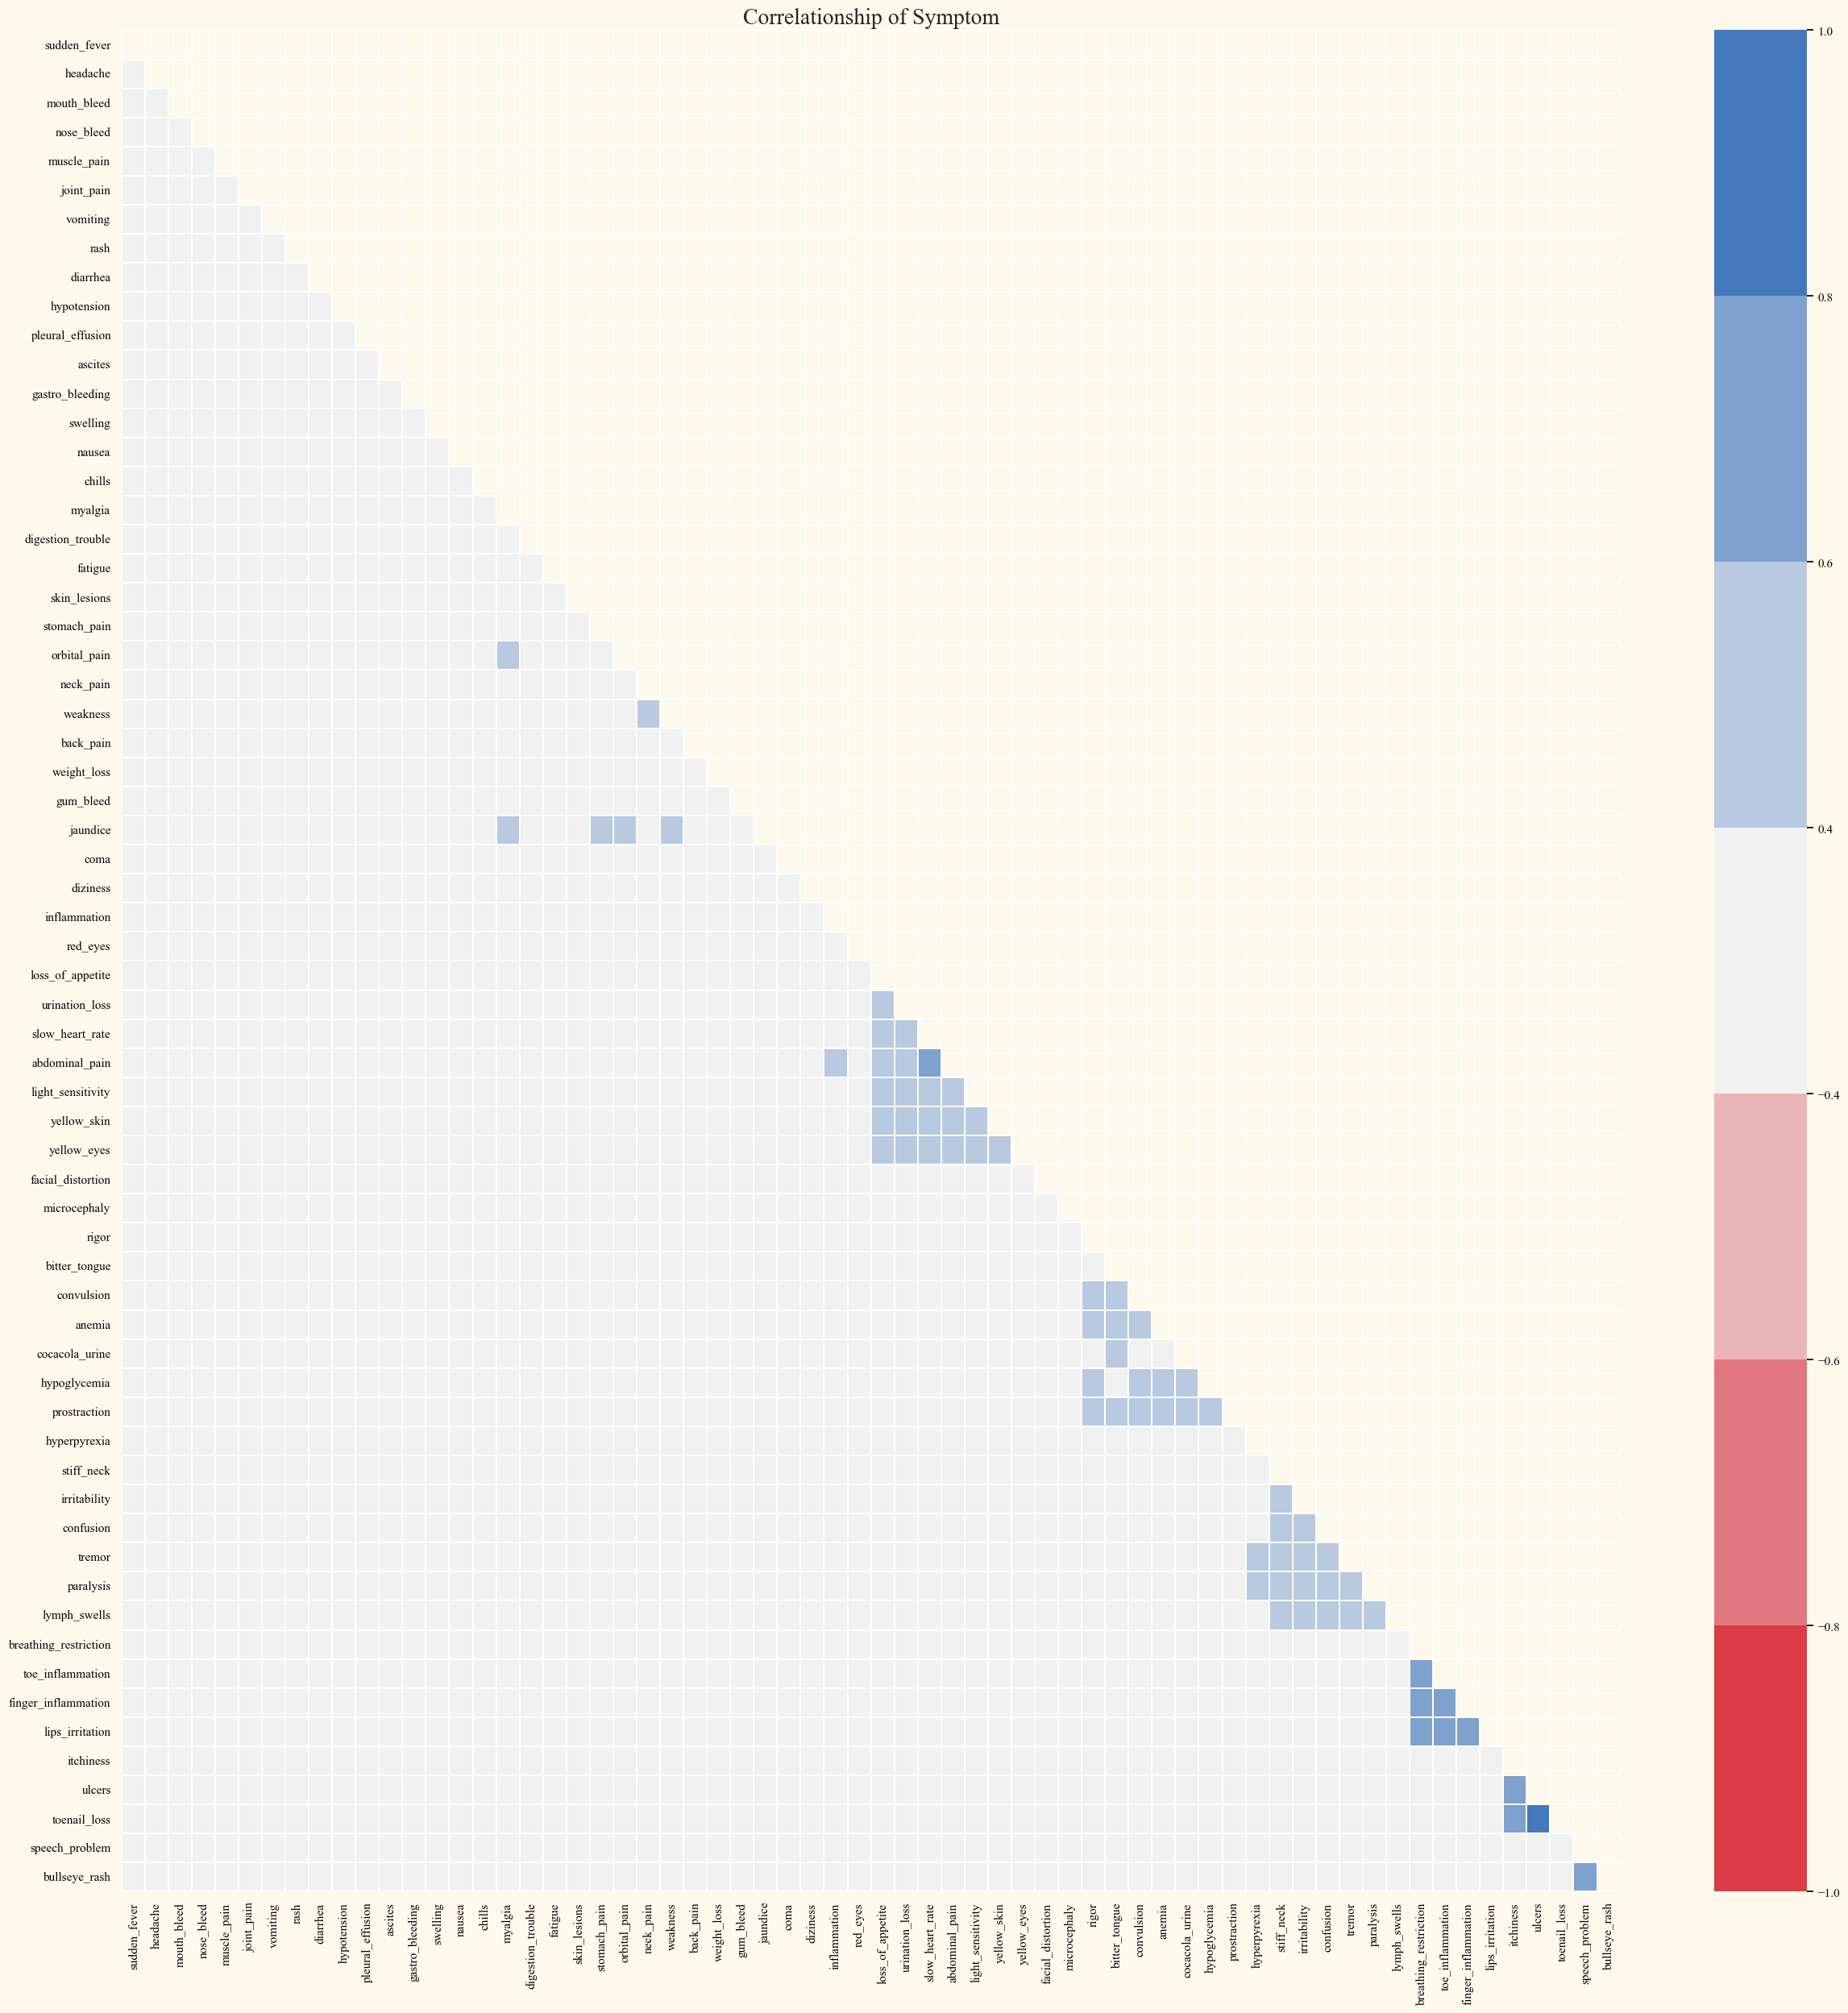

In [737]:
title = "Correlationship of Symptom"

mask = np.triu(np.ones_like(df.corr()))

fig = plt.figure(figsize = (30,30))

ax = fig.add_subplot()

sns.heatmap(df.corr() , mask = mask, linewidths = .1,
            norm = norm, # 색상의 범위 설정 
            cmap = cmap,
            ax = ax)

ax.set_title(title,
                fontdict = {'size':20})

### 막대그래프마다 원하는 색상 지정하기 

Text(0.5, 1.0, 'Most common & uncommon prognosis')

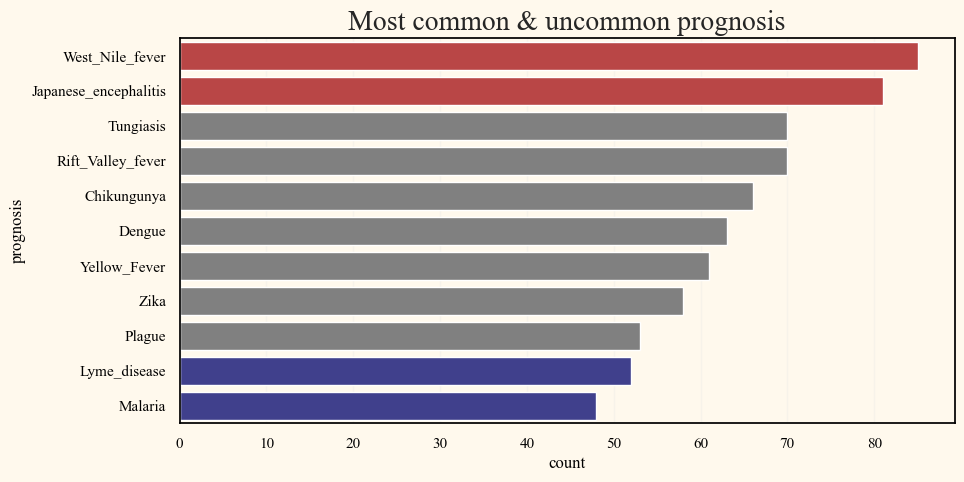

In [738]:
order = df['prognosis'].value_counts().index

colors = ['gray'] * len(order)

colors = ['#CC3333' if i < 2 else '#333399' if i > len(order) - 3 else var for i,var in enumerate(colors)]

plt.figure(figsize = (10,5))

sns.countplot(data = df ,
                y = 'prognosis',
                order = order,
                palette = colors)

plt.title('Most common & uncommon prognosis',
            fontsize = 20)

Text(0.5, 1.0, 'incidence rate of symptoms by disease')

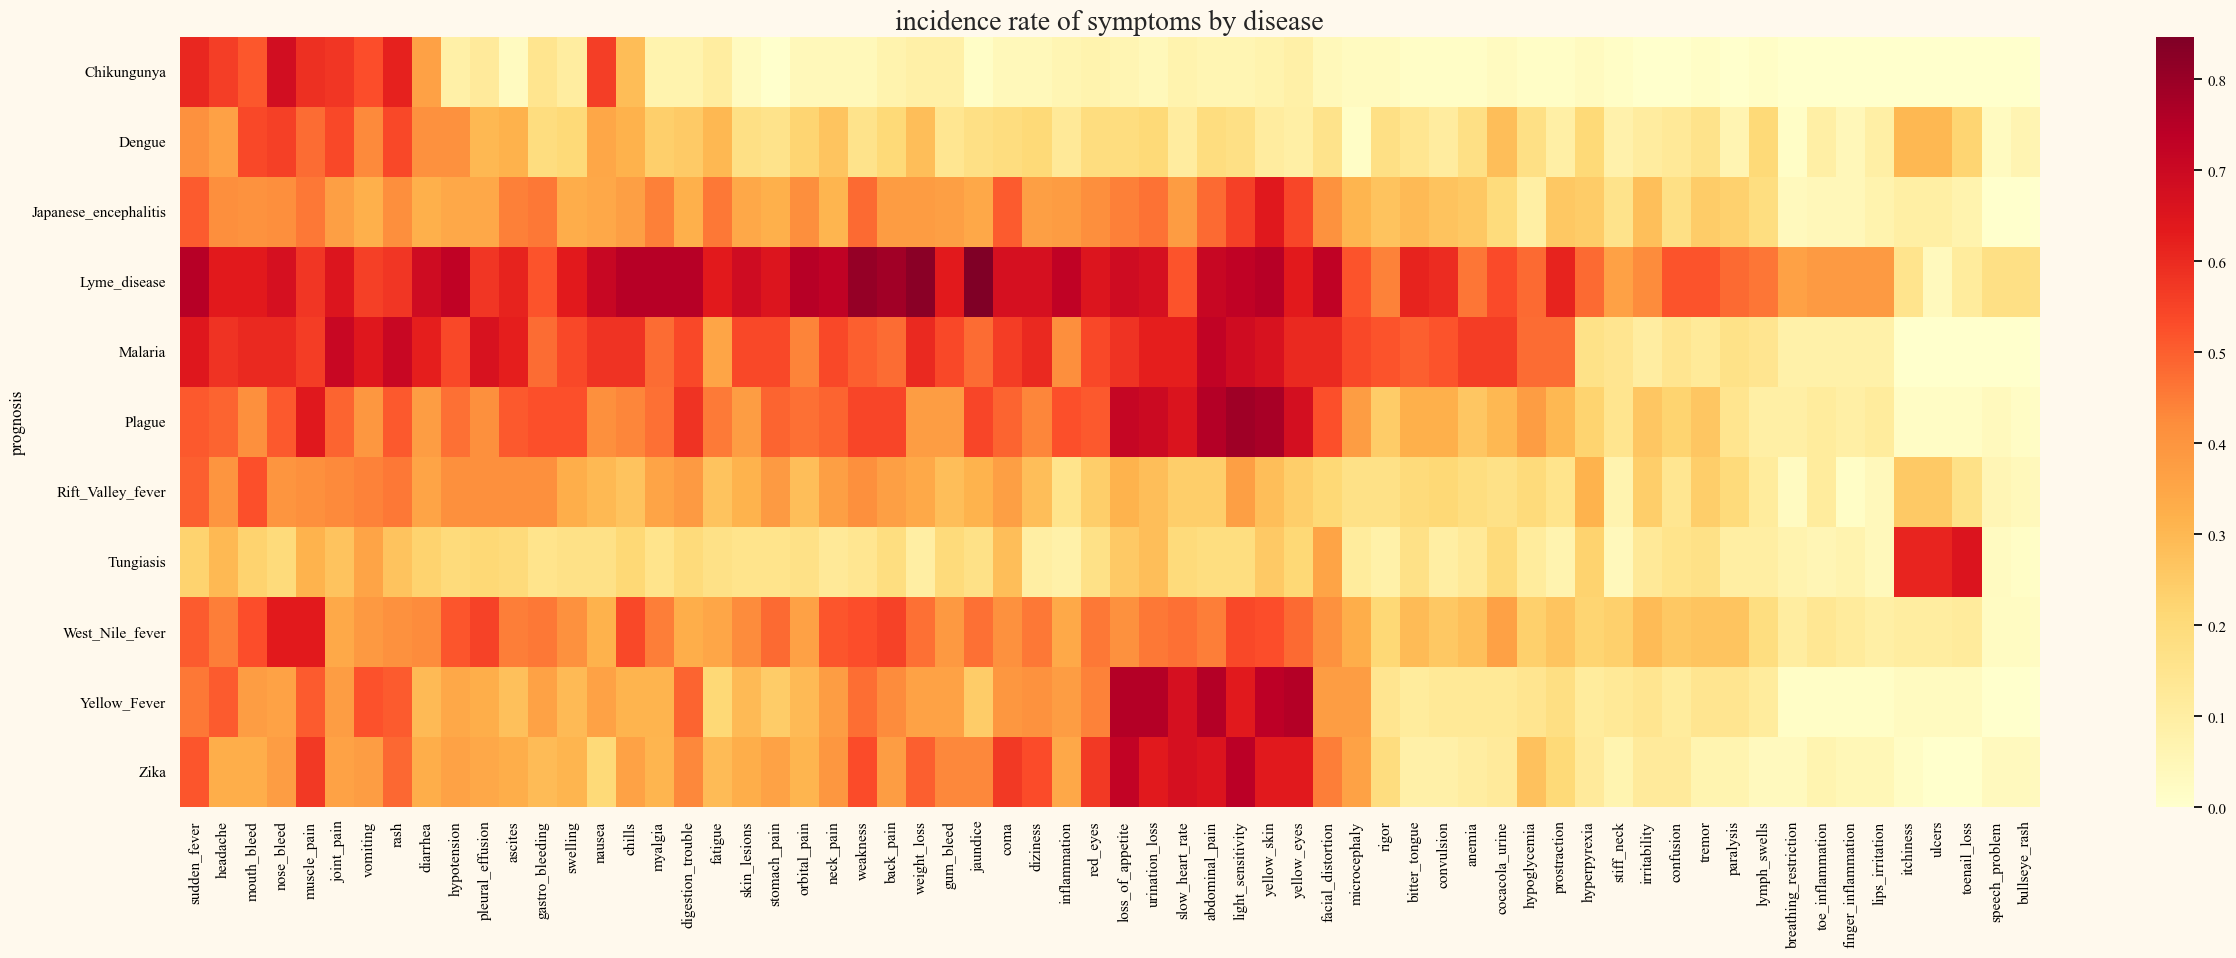

In [739]:
plt.figure(figsize = (30,10))

sns.heatmap(df.groupby('prognosis').mean(), # 질병 별 증상의 유병률을 평균으로 내어 표현하기
            cmap = 'YlOrRd')

plt.title('incidence rate of symptoms by disease',
            fontsize = 20)

### 변수 중요도 선택

In [740]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

In [741]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X,Y)

RandomForestClassifier(n_estimators=1000)

<AxesSubplot:xlabel='feature_importance', ylabel='feature_name'>

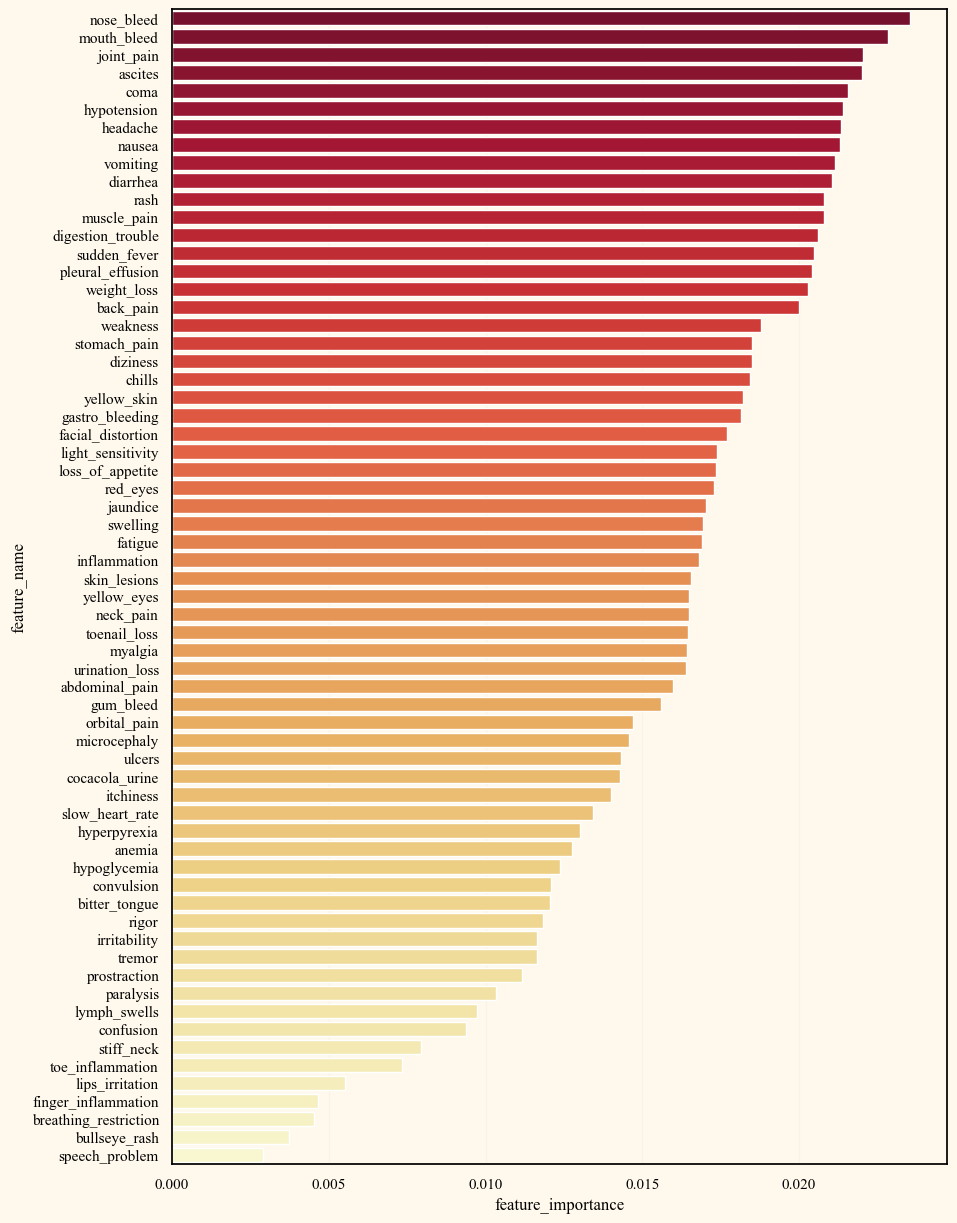

In [742]:
importance = pd.DataFrame({'feature_name' : X.columns,
            'feature_importance': rf.feature_importances_}).sort_values(by = 'feature_importance',
                                                                        ascending = False)


plt.figure(figsize = (10,15))

sns.barplot(data = importance,
            x = 'feature_importance',
            y = 'feature_name',
            palette = 'YlOrRd_r')

# 모델링

* GPU 를 가져와서 속도를 빠르게 해보자

In [786]:
from sklearn.model_selection import train_test_split,KFold


import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform

from sklearn.preprocessing import OrdinalEncoder
from keras.utils import to_categorical

In [744]:
enc = OrdinalEncoder()

y = enc.fit_transform(df[['prognosis']])

y = to_categorical(y)

N_ClASSES = len(enc.categories_)

In [775]:
def create_model(INPUT_SHAPE = X.shape[1:],
                N_ClASSES = len(enc.categories_[0]),
                LAYERS = 3,
                L2 = 0.01,
                FRIST_NODE = 64,
                HIDDEN_NODE = 32,
                DROPOUT_RATE = .2
                ):

    inputs = layers.Input(shape = INPUT_SHAPE)

    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(FRIST_NODE, activation = 'relu')(x)

    for _ in range(LAYERS):
        x = layers.BatchNormalization()(x)
        x = layers.Dense(HIDDEN_NODE, kernel_regularizer=regularizers.l2(L2))(x)
        x = layers.Dropout(DROPOUT_RATE)(x)
        
    outputs = layers.Dense(units = N_ClASSES,activation = 'softmax')(x)    


    return (keras.Model(inputs,outputs))

In [776]:
optimizers = {'optimizer':tf.keras.optimizers.legacy.Adam(learning_rate = .01),
                'loss':CategoricalCrossentropy(),
                'metrics':['accuracy']}

In [777]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100)

In [778]:
def mpk(y_test, predicted):
    """
    Calculates the mean precision at k for a given set of predictions.
    Args:
        y_test (np.ndarray): Actual values for the test set
        predicted (np.ndarray): Predicted values for the test set
    Returns:
        mpk_score (float): Mean precision at k score for the test set
    """
    k = 3
    mpk_score = 0
    for i, y in enumerate(y_test):
        top_k_preds = predicted[i].argsort()[-k:][::-1]
        mpk_score += np.mean([1 if np.argmax(y) in top_k_preds[:j+1] else 0 for j in range(k)])
    mpk_score /= len(y_test)
    return mpk_score

In [984]:
def fold_fold_test(X,y,
                    TEST_ITERATION = 5,
                    N_SPLIT = 5,
                    EPOCHS = 9999,
                    N_ClASSES = len(enc.categories_[0]),
                    LAYERS = 3,
                    L2 = 0.01,
                    FIRST_NODE = 64,
                    HIDDEN_NODE = 32,
                    DROPOUT_RATE = .2,
                    PRINT = True
                    ):

    input_shape_ = X.shape[1:]
    
    CV = KFold(n_splits = N_SPLIT, random_state = 42, shuffle = True)

    total_mpk_socre = 0

    for num in range(TEST_ITERATION):
        
        x_train,x_test,y_train,y_test = train_test_split(X,y, stratify = y,
                                                            random_state = 42 + num) 
        
        avg_mpk_score = 0

        for i,(train_idx, test_idx) in enumerate(CV.split(x_train,y_train)):
            
            train_x,train_y = x_train.iloc[train_idx],y_train[train_idx]
            valid_x,valid_y = x_train.iloc[test_idx],y_train[test_idx]
            
            model = create_model(INPUT_SHAPE = input_shape_,
                                N_ClASSES = len(enc.categories_[0]),
                                LAYERS = LAYERS,
                                L2 = L2,
                                FRIST_NODE = FIRST_NODE,
                                HIDDEN_NODE = HIDDEN_NODE,
                                DROPOUT_RATE = DROPOUT_RATE)
            
            model.compile(**optimizers)
            
            model.fit(train_x,train_y,
                        validation_data = (valid_x,valid_y),
                        epochs = EPOCHS,
                        callbacks = [early_stopping],
                        verbose = 0)
            
            predicted = model.predict(valid_x,
                                        verbose = 0)
            
            avg_mpk_score += mpk(valid_y,predicted)
            
        total_mpk_socre += avg_mpk_score / (TEST_ITERATION * N_SPLIT) 
        
        if PRINT == True:
        
            print(num + 1,'번 째 FOLD :', avg_mpk_score / N_SPLIT)
        
        
        
    if PRINT == True:

        print('5 x 5 교차 검증의 평균 점수 :',total_mpk_socre)
    
    return total_mpk_socre

In [867]:
fold_fold_test(X,y)

1 번 째 FOLD : 0.3685534591194969
2 번 째 FOLD : 0.3761006289308176
3 번 째 FOLD : 0.3867924528301887
4 번 째 FOLD : 0.3704402515723271
5 번 째 FOLD : 0.3547169811320754
5 x 5 교차 검증의 평균 점수 : 0.3713207547169811


0.3713207547169811

* Feature Importance 가 작았던 변수는 제거하고 시행

In [868]:
low_imporatnce = importance[-2:]['feature_name'].values

drop_df = df.drop(low_imporatnce,axis = 1)


X_drop = drop_df.iloc[:, :-1]
y_drop = enc.fit_transform(drop_df[['prognosis']])

y_drop = to_categorical(y_drop)

In [869]:
fold_fold_test(X_drop,y_drop)

1 번 째 FOLD : 0.3685534591194969
2 번 째 FOLD : 0.3779874213836477
3 번 째 FOLD : 0.38113207547169814
4 번 째 FOLD : 0.3779874213836479
5 번 째 FOLD : 0.3792452830188679
5 x 5 교차 검증의 평균 점수 : 0.3769811320754718


0.3769811320754718

* 불필요한 변수를 제거한 경우가 MAP@3 의 점수가 0.005 이상 더 높았다.

In [985]:
# 적절한 layer 와 node 갯수 찾기 
# 다양한 경우의 수가 있을 수 있으나 은닉층의 node 갯수만 바꿔 가며 시도해보자 

Nodes = [8,16,32,64]
Layers = [1,2,3,4,5]


mpk_score = {}

for node in Nodes:
    for layer in Layers:
        
        avg_mpk = fold_fold_test(X_drop,y_drop,
                                TEST_ITERATION = 3,
                                HIDDEN_NODE = node,
                                LAYERS = layer,
                                PRINT = False) # 5 번의 교차 검증을 3번만 하자
        
        print(f'node : {node} , layer : {layer} : ', avg_mpk )
        
        mpk_score[f'node : {node} , layer : {layer}'] = avg_mpk

node : 8 , layer : 1 :  0.3909853249475891
node : 8 , layer : 2 :  0.3721174004192872
node : 8 , layer : 3 :  0.36498951781970645
node : 8 , layer : 4 :  0.3436058700209643
node : 8 , layer : 5 :  0.3486373165618448
node : 16 , layer : 1 :  0.38784067085953877
node : 16 , layer : 2 :  0.37379454926624744
node : 16 , layer : 3 :  0.3712788259958071
node : 16 , layer : 4 :  0.36855345911949683
node : 16 , layer : 5 :  0.36331236897274627
node : 32 , layer : 1 :  0.3719077568134172
node : 32 , layer : 2 :  0.36792452830188677
node : 32 , layer : 3 :  0.3656184486373166
node : 32 , layer : 4 :  0.37651991614255764
node : 32 , layer : 5 :  0.35723270440251575
node : 64 , layer : 1 :  0.37274633123689727
node : 64 , layer : 2 :  0.37463312368972745
node : 64 , layer : 3 :  0.37924528301886795
node : 64 , layer : 4 :  0.37798742138364777
node : 64 , layer : 5 :  0.3660377358490566


In [986]:
result = (pd.DataFrame(mpk_score,index = range(len(mpk_score))))

result = pd.melt(result).groupby('variable').mean().reset_index().sort_values(by = 'value', ascending = False)

result.head()

,variable,value
15,"node : 8 , layer : 1",0.390985
0,"node : 16 , layer : 1",0.387841
12,"node : 64 , layer : 3",0.379245
13,"node : 64 , layer : 4",0.377987
8,"node : 32 , layer : 4",0.376520


Text(0.5, 1.0, 'MAP@3 according to Node & Layer')

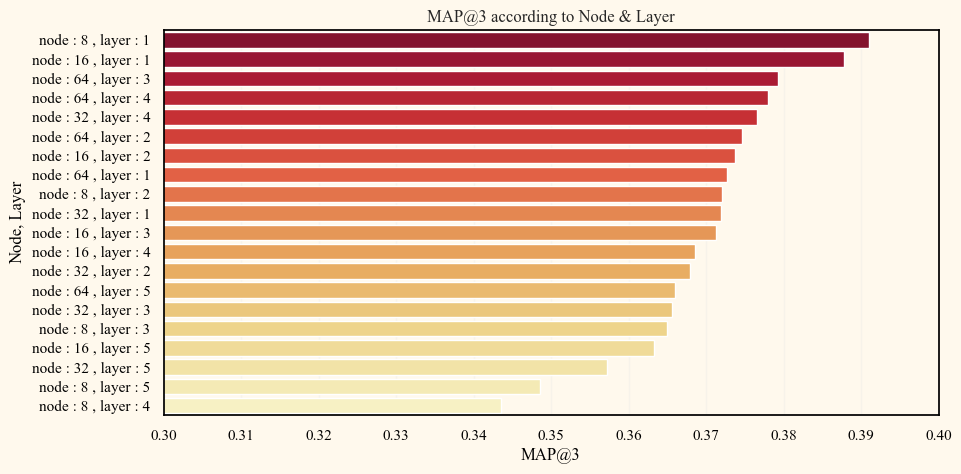

In [996]:
plt.figure(figsize = (10,5))

sns.barplot(data = result,
            x = 'value',
            y = 'variable',
            palette = 'YlOrRd_r')
plt.xlabel('MAP@3')
plt.ylabel('Node, Layer')
plt.xlim([0.30, 0.4])
plt.xticks(ticks = np.arange(0.30,0.41,0.01));
plt.title('MAP@3 according to Node & Layer')

* Node 가 8, layer 가 3인 모델의 MAP@3 점수가 가장 높았다.
* 가장 점수가 높았던 두 모델의 조건을 가지고 dropout 과 l2 하이퍼 파라미터를 찾은 후 제출해보자

In [1001]:
dropout_rates = [0,0.1,0.2,0.3]
l2_rates = [0,0.1,0.01]

node_8_layer_1 = {}

for drop in dropout_rates:
    for l2 in l2_rates:
        
        avg_mpk = fold_fold_test(X,y,
                        TEST_ITERATION = 3,
                        HIDDEN_NODE = 8,
                        LAYERS = 1,
                        PRINT = False) 
        
        print(f'dropout : {drop}, l2_reg : {l2}', avg_mpk )
        
        node_8_layer_1[f'dropout : {drop}, l2_reg : {l2}'] = avg_mpk

dropout : 0, l2_reg : 0 0.3876310272536687
dropout : 0, l2_reg : 0.1 0.41069182389937103
dropout : 0, l2_reg : 0.01 0.37547169811320746
dropout : 0.1, l2_reg : 0 0.39119496855345903
dropout : 0.1, l2_reg : 0.1 0.3872117400419287
dropout : 0.1, l2_reg : 0.01 0.3729559748427673
dropout : 0.2, l2_reg : 0 0.38155136268343814
dropout : 0.2, l2_reg : 0.1 0.3859538784067086
dropout : 0.2, l2_reg : 0.01 0.38008385744234796
dropout : 0.3, l2_reg : 0 0.3935010482180294
dropout : 0.3, l2_reg : 0.1 0.38280922431865827
dropout : 0.3, l2_reg : 0.01 0.39517819706498947


In [1000]:
dropout_rates = [0,0.1,0.2,0.3]
l2_rates = [0,0.1,0.01]

node_16_layer_1 = {}

for drop in dropout_rates:
    for l2 in l2_rates:
        
        avg_mpk = fold_fold_test(X,y,
                        TEST_ITERATION = 3,
                        HIDDEN_NODE = 16,
                        LAYERS = 3,
                        PRINT = False) 
        
        print(f'dropout : {drop}, l2_reg : {l2}', avg_mpk )
        
        node_16_layer_1[f'dropout : {drop}, l2_reg : {l2}'] = avg_mpk

dropout : 0, l2_reg : 0 0.3756813417190776
dropout : 0, l2_reg : 0.1 0.3689727463312369
dropout : 0, l2_reg : 0.01 0.3633123689727463
dropout : 0.1, l2_reg : 0 0.3675052410901467
dropout : 0.1, l2_reg : 0.1 0.3748427672955975
dropout : 0.1, l2_reg : 0.01 0.3628930817610063
dropout : 0.2, l2_reg : 0 0.3825995807127882
dropout : 0.2, l2_reg : 0.1 0.3794549266247379
dropout : 0.2, l2_reg : 0.01 0.3817610062893082
dropout : 0.3, l2_reg : 0 0.37002096436058696
dropout : 0.3, l2_reg : 0.1 0.3662473794549266
dropout : 0.3, l2_reg : 0.01 0.3784067085953878


In [998]:
dropout_rates = [0,0.1,0.2,0.3]
l2_rates = [0,0.1,0.01]

node_64_layer_3 = {}

for drop in dropout_rates:
    for l2 in l2_rates:
        
        avg_mpk = fold_fold_test(X,y,
                        TEST_ITERATION = 3,
                        HIDDEN_NODE = 64,
                        LAYERS = 3,
                        PRINT = False) 
        
        print(f'dropout : {drop}, l2_reg : {l2}', avg_mpk )
        
        node_64_layer_3[f'dropout : {drop}, l2_reg : {l2}'] = avg_mpk

dropout : 0, l2_reg : 0 0.3740041928721174
dropout : 0, l2_reg : 0.1 0.3761006289308176
dropout : 0, l2_reg : 0.01 0.3662473794549267
dropout : 0.1, l2_reg : 0 0.36855345911949683
dropout : 0.1, l2_reg : 0.1 0.36876310272536683
dropout : 0.1, l2_reg : 0.01 0.3740041928721174
dropout : 0.2, l2_reg : 0 0.38469601677148846
dropout : 0.2, l2_reg : 0.1 0.37966457023060796
dropout : 0.2, l2_reg : 0.01 0.3763102725366876
dropout : 0.3, l2_reg : 0 0.37505241090146746
dropout : 0.3, l2_reg : 0.1 0.3779874213836478
dropout : 0.3, l2_reg : 0.01 0.36163522012578614


In [1010]:
def make_df(dictionary):
    
    pre_df = pd.DataFrame(dictionary, index = range(len(dictionary)))
    
    result = pd.melt(pre_df).groupby('variable').mean().reset_index()
    
    return result.sort_values(by = 'value', ascending = False)

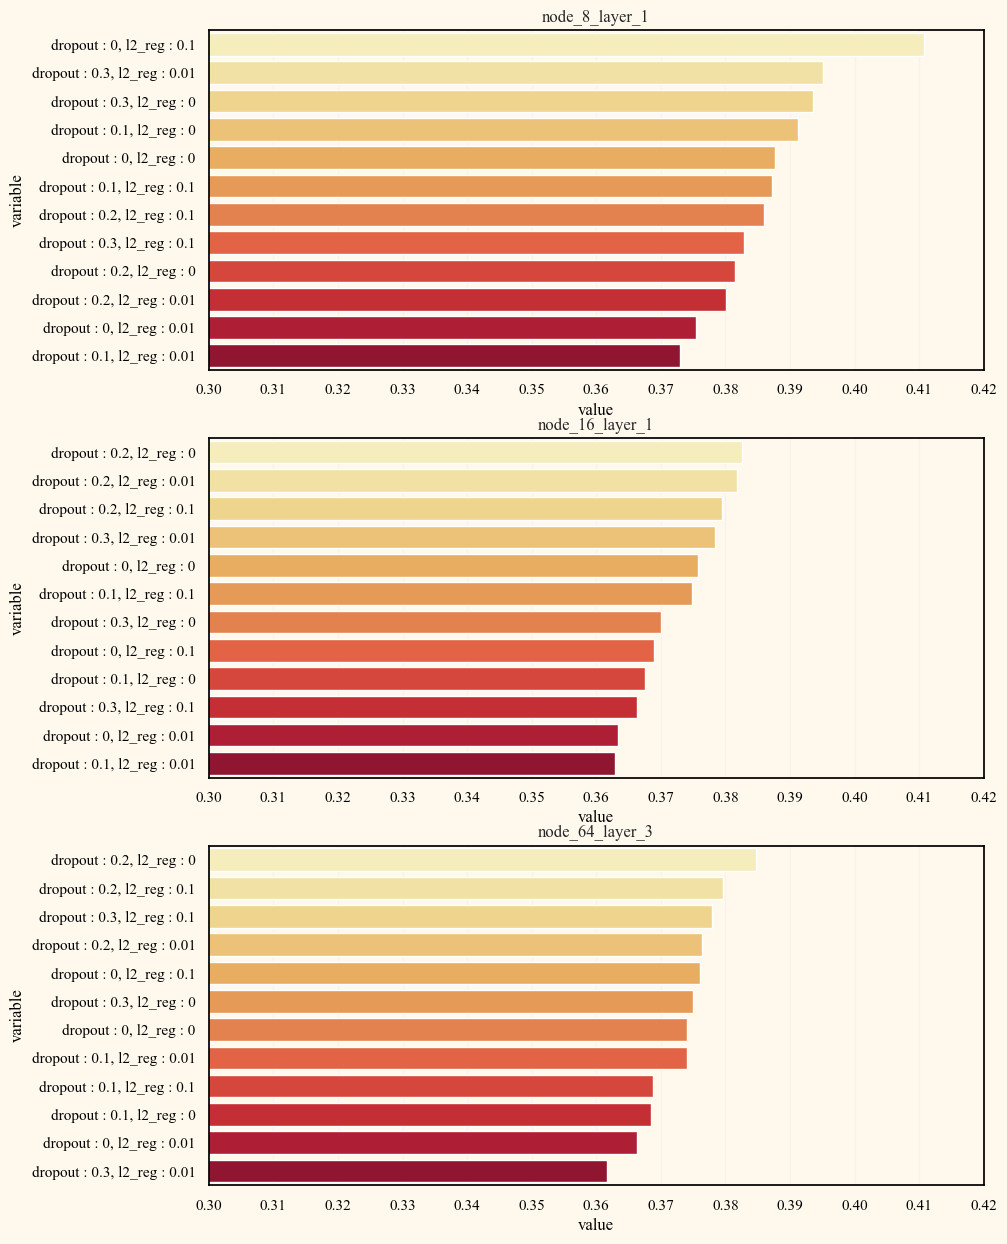

In [1224]:
cv_list = [node_8_layer_1, node_16_layer_1, node_64_layer_3]
title_list = ['node_8_layer_1', 'node_16_layer_1','node_64_layer_3']
fig,ax = plt.subplots(nrows = 3, figsize = (10,15))

for i,var in enumerate(cv_list):
    
    sns.barplot(data = make_df(var),
                x = 'value',
                y = 'variable',
                ax = ax[i],
                palette = 'YlOrRd')
    ax[i].set_xticks(ticks = np.arange(0.30,0.45,0.01));
    ax[i].set_xlim([0.3,0.42])
    ax[i].set_title(title_list[i])


In [1148]:
RESULT_MODEL = create_model(HIDDEN_NODE = 8,
            LAYERS = 1,
            DROPOUT_RATE = 0,
            L2 = 0.1,
            INPUT_SHAPE = X_drop.shape[1:])

RESULT_MODEL.compile(**optimizers)

In [1149]:
x_train,x_test,y_train,y_test = train_test_split(X_drop, y_drop, stratify = y_drop,
                                                    test_size = 0.2, random_state = 42)

In [1150]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 40)


history = RESULT_MODEL.fit(x_train,y_train,
                            validation_data = (x_test,y_test),
                            epochs = 9999,
                            callbacks = [early_stopping],
                            verbose = 0)

Text(0.5, 0.98, 'node : 8 , layer : 1 \n MPK : 0.385')

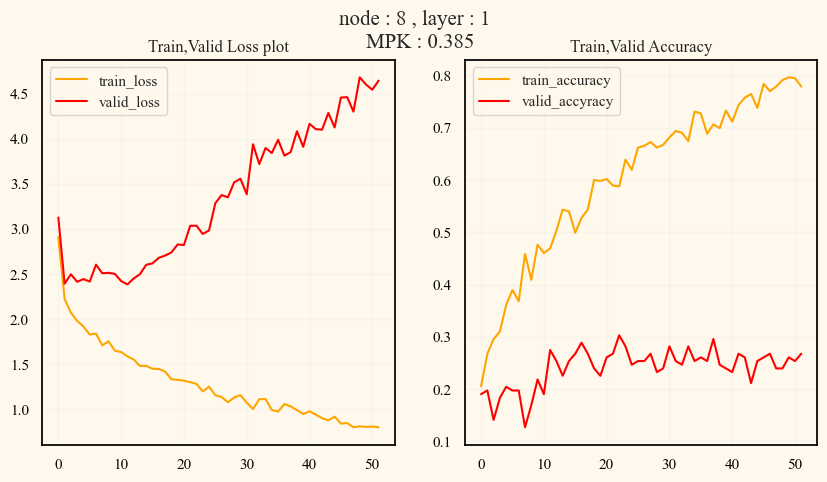

In [1151]:

result_mpk = mpk(y_test,RESULT_MODEL.predict(x_test, verbose = 0))

fig,ax = plt.subplots(ncols = 2, figsize = (10,5))

ax[0].plot(history.history['loss'],c = 'orange', label = 'train_loss')
ax[0].plot(history.history['val_loss'],c = 'red', label = 'valid_loss')
ax[0].legend(loc = 'upper left')
ax[0].set_title('Train,Valid Loss plot')

ax[1].plot(history.history['accuracy'],c = 'orange', label = 'train_accuracy')
ax[1].plot(history.history['val_accuracy'],c = 'red', label = 'valid_accyracy')

ax[1].legend(loc = 'upper left')
ax[1].set_title('Train,Valid Accuracy')

fig.suptitle(f'node : 8 , layer : 1 \n MPK : {result_mpk:.3f}',fontsize = 15)

In [1212]:
test = pd.read_csv('C:/Users/whileduck/Desktop/캐글/test.csv').drop('id',axis = 1)

probs = RESULT_MODEL.predict(test.drop(low_imporatnce,axis = 1))

last_result = []

for prob in probs:
    
    last_result.append(prob.argsort()[-3:][::-1])

10/10 [==============================] - 0s 740us/step


In [1220]:
def sub_maker(result):
    
    transfer = {}

    for i,var in enumerate(enc.categories_[0]):
        
        transfer[i] = var
    
    pre_result = pd.DataFrame(result)
    
    for col in pre_result.columns:
        
        pre_result[col] = pre_result[col].map(transfer)
        
    pre_result['result'] = pre_result[0] + ' ' + pre_result[1] + ' ' + pre_result[2]
    
    return pre_result['result']

In [1221]:
sub['prognosis'] = sub_maker(last_result)

sub

,id,prognosis
0,707,Rift_Valley_fever Tungiasis Dengue
1,708,Malaria Chikungunya Plague
2,709,West_Nile_fever Japanese_encephalitis Lyme_dis...
3,710,Tungiasis Rift_Valley_fever Japanese_encephalitis
4,711,Malaria Yellow_Fever Zika
...,...,...
298,1005,Yellow_Fever Plague Japanese_encephalitis
299,1006,Lyme_disease Malaria West_Nile_fever
300,1007,Plague Lyme_disease Malaria
301,1008,Rift_Valley_fever Japanese_encephalitis Tungiasis


In [1223]:
sub.to_csv('C:/Users/whileduck/Desktop/캐글/node_8,layer_1.csv',index = False)